In [61]:
import numpy as np
import pandas as pd
import networkx as nx
import sklearn
import scipy
import scipy.sparse as spa
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(precision=3)
np.set_printoptions(threshold=999)

### 데이터 불러오기

In [71]:
df = pd.read_csv("./df.csv")

### 데이터 확인

In [72]:
#비율 확인
fraud_counts = df['fraud'].value_counts()
fraud_counts

fraud
0    10627
1     1971
Name: count, dtype: int64

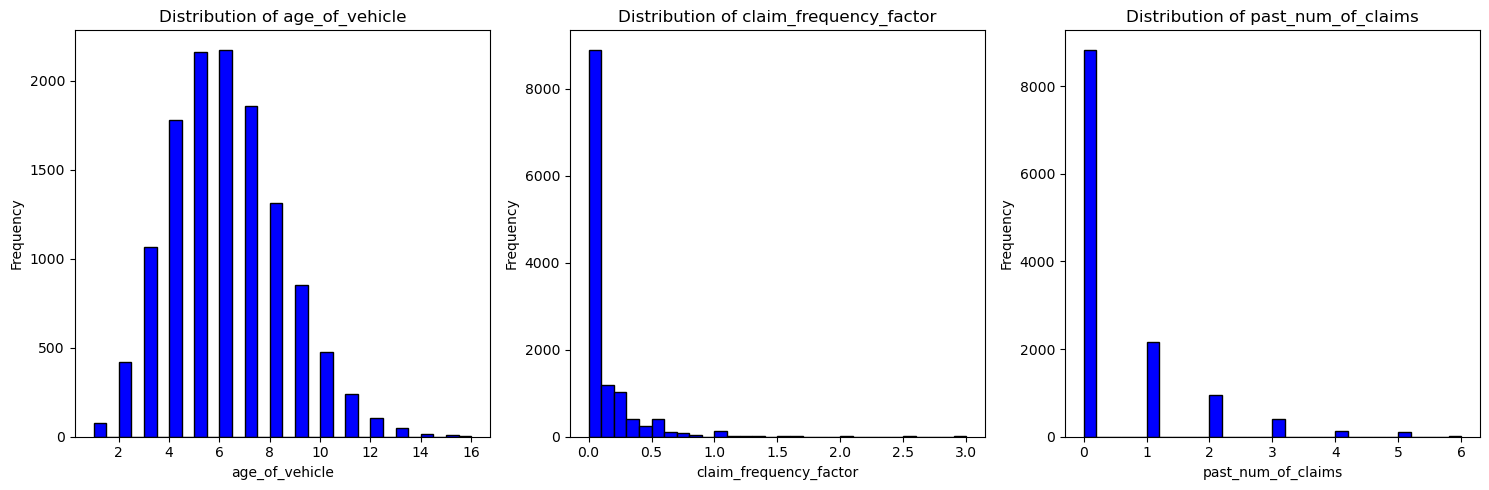

In [73]:
import matplotlib.pyplot as plt

# Selecting the relevant columns for plotting
columns_to_plot = ['age_of_vehicle', 'claim_frequency_factor', 'past_num_of_claims']

# Plotting the distribution of each variable
plt.figure(figsize=(15, 5))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(1, 3, i)
    plt.hist(df[column], bins=30, color='blue', edgecolor='black')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

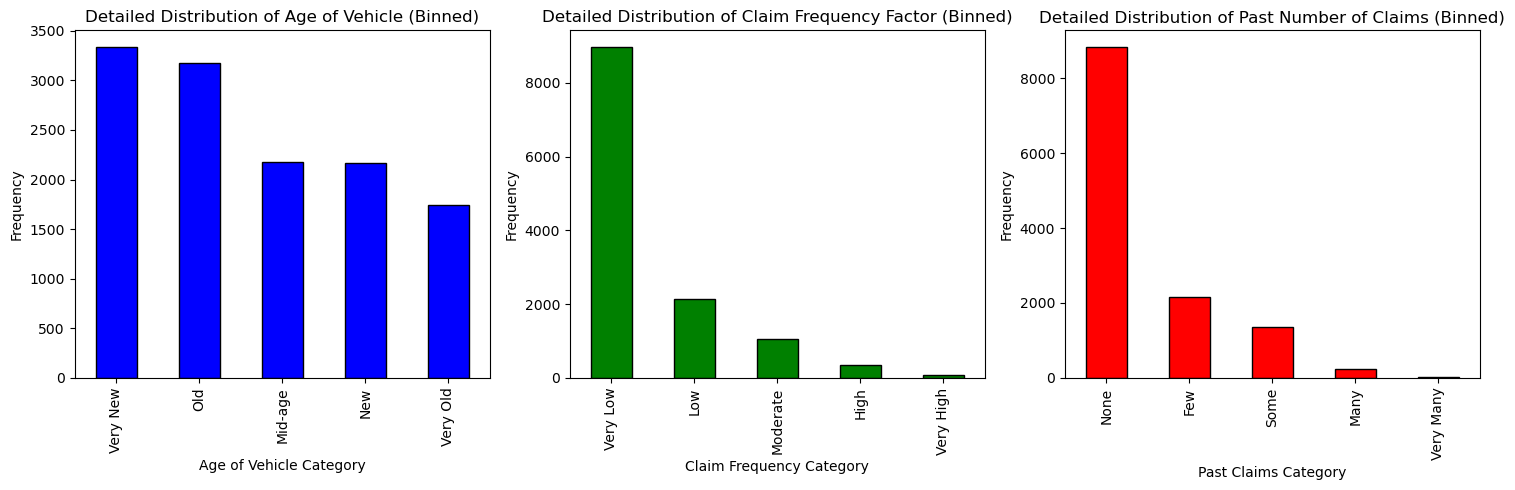

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

# Re-assign the age_of_vehicle binned variable using a more detailed approach
df['age_of_vehicle_binned'] = pd.qcut(df['age_of_vehicle'], q=5, labels=["Very New", "New", "Mid-age", "Old", "Very Old"])

# Binning 'claim_frequency_factor' into more detailed categories
df['claim_frequency_binned'] = pd.cut(df['claim_frequency_factor'], 
                                      bins=[-0.1, 0.1, 0.3, 0.6, 1, df['claim_frequency_factor'].max()], 
                                      labels=["Very Low", "Low", "Moderate", "High", "Very High"])

# Binning 'past_num_of_claims' into more detailed categories
df['past_claims_binned'] = pd.cut(df['past_num_of_claims'], 
                                  bins=[-0.1, 0, 1, 3, 5, df['past_num_of_claims'].max()], 
                                  labels=["None", "Few", "Some", "Many", "Very Many"])

# Plotting the new distributions
plt.figure(figsize=(15, 5))

# Plot for age_of_vehicle_binned
plt.subplot(1, 3, 1)
df['age_of_vehicle_binned'].value_counts().plot(kind='bar', color='blue', edgecolor='black')
plt.title('Detailed Distribution of Age of Vehicle (Binned)')
plt.xlabel('Age of Vehicle Category')
plt.ylabel('Frequency')

# Plot for claim_frequency_binned
plt.subplot(1, 3, 2)
df['claim_frequency_binned'].value_counts().plot(kind='bar', color='green', edgecolor='black')
plt.title('Detailed Distribution of Claim Frequency Factor (Binned)')
plt.xlabel('Claim Frequency Category')
plt.ylabel('Frequency')

# Plot for past_claims_binned
plt.subplot(1, 3, 3)
df['past_claims_binned'].value_counts().plot(kind='bar', color='red', edgecolor='black')
plt.title('Detailed Distribution of Past Number of Claims (Binned)')
plt.xlabel('Past Claims Category')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


### 비율 재조정 (30% valid) 

In [75]:
# 사기 청구의 30%를 '알 수 없음'(2)으로 처리
num_fraudulent = df['fraud'].value_counts()[1]  # 사기 청구의 총 개수
num_unknown_fraud = int(num_fraudulent * 0.3)  # 알 수 없음으로 변경할 사기 청구의 수

# 비사기 청구의 30%를 '알 수 없음'(2)으로 처리
num_non_fraudulent = df['fraud'].value_counts()[0]  # 비사기 청구의 총 개수
num_unknown_non_fraud = int(num_non_fraudulent * 0.3)  # 알 수 없음으로 변경할 비사기 청구의 수

# 랜덤하게 30%를 '알 수 없음'(2)으로 설정
unknown_indices_fraud = df[df['fraud'] == 1].sample(n=num_unknown_fraud, random_state=42).index
unknown_indices_non_fraud = df[df['fraud'] == 0].sample(n=num_unknown_non_fraud, random_state=42).index

# fraud_updated 열 생성
df['fraud_updated'] = df['fraud']  # 사기와 비사기 청구를 그대로 복사
df.loc[unknown_indices_fraud, 'fraud_updated'] = 2
df.loc[unknown_indices_non_fraud, 'fraud_updated'] = 2

# 업데이트된 비율 계산
updated_fraud_ratio = df['fraud_updated'].value_counts(normalize=True)

updated_fraud_ratio


fraud_updated
0    0.590491
2    0.299968
1    0.109541
Name: proportion, dtype: float64

In [76]:
df['fraud_updated'].value_counts()

fraud_updated
0    7439
2    3779
1    1380
Name: count, dtype: int64

In [77]:
df.to_csv("./org_fraud_df.csv")

### Networks 

In [78]:
import networkx as nx

# 그래프 초기화
G = nx.Graph()

# P1 ~ P15 노드 추가 
# Add nodes P1 ~ P15
G.add_nodes_from([
    ("P1", {"claims": 0, "fraudulent": 0, "non-fraudulent": 0}),
    ("P2", {"claims": 0, "fraudulent": 0, "non-fraudulent": 0}),
    ("P3", {"claims": 0, "fraudulent": 0, "non-fraudulent": 0}),
    ("P4", {"claims": 0, "fraudulent": 0, "non-fraudulent": 0}),
    ("P5", {"claims": 0, "fraudulent": 0, "non-fraudulent": 0}),
    ("P6", {"claims": 0, "fraudulent": 0, "non-fraudulent": 0}),
    ("P7", {"claims": 0, "fraudulent": 0, "non-fraudulent": 0}),
    ("P8", {"claims": 0, "fraudulent": 0, "non-fraudulent": 0}),
    ("P9", {"claims": 0, "fraudulent": 0, "non-fraudulent": 0}),
    ("P10", {"claims": 0, "fraudulent": 0, "non-fraudulent": 0}),
    ("P11", {"claims": 0, "fraudulent": 0, "non-fraudulent": 0}),
    ("P12", {"claims": 0, "fraudulent": 0, "non-fraudulent": 0}),
    ("P13", {"claims": 0, "fraudulent": 0, "non-fraudulent": 0}),
    ("P14", {"claims": 0, "fraudulent": 0, "non-fraudulent": 0}),
    ("P15", {"claims": 0, "fraudulent": 0, "non-fraudulent": 0}),
], bipartite=0)

# 청구 노드 추가
for index, row in df.iterrows():
    claim_id = f"C{index+1}"
    label = row['fraud_updated']  # 'fraud_updated' 열의 값을 label로 설정
    G.add_node(claim_id, label=label, bipartite=1)

    # 엣지 추가
    # Age of Vehicle
    if row['age_of_vehicle_binned'] == "Very New":
        G.add_edge("P1", claim_id, weight=1)
    elif row['age_of_vehicle_binned'] == "New":
        G.add_edge("P2", claim_id, weight=1)
    elif row['age_of_vehicle_binned'] == "Mid-age":
        G.add_edge("P3", claim_id, weight=1)
    elif row['age_of_vehicle_binned'] == "Old":
        G.add_edge("P4", claim_id, weight=1)
    elif row['age_of_vehicle_binned'] == "Very Old":
        G.add_edge("P5", claim_id, weight=1)

    # Claim Frequency
    if row['claim_frequency_binned'] == "Very Low":
        G.add_edge("P6", claim_id, weight=1)
    elif row['claim_frequency_binned'] == "Low":
        G.add_edge("P7", claim_id, weight=1)
    elif row['claim_frequency_binned'] == "Moderate":
        G.add_edge("P8", claim_id, weight=1)
    elif row['claim_frequency_binned'] == "High":
        G.add_edge("P9", claim_id, weight=1)
    elif row['claim_frequency_binned'] == "Very High":
        G.add_edge("P10", claim_id, weight=1)

    # Past Claims
    if row['past_claims_binned'] == "None":
        G.add_edge("P11", claim_id, weight=1)
    elif row['past_claims_binned'] == "Few":
        G.add_edge("P12", claim_id, weight=1)
    elif row['past_claims_binned'] == "Some":
        G.add_edge("P13", claim_id, weight=1)
    elif row['past_claims_binned'] == "Many":
        G.add_edge("P14", claim_id, weight=1)
    elif row['past_claims_binned'] == "Very Many":
        G.add_edge("P15", claim_id, weight=1)
# 노드와 엣지의 개수 출력
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

num_nodes, num_edges

(12613, 37782)

In [79]:
num_nodes

12613

In [80]:

# 각 엣지에 대해 가중치를 업데이트
updated_edges = []
for u, v, d in G.edges(data=True):
    # 엣지 가중치를 두 노드의 차수의 곱의 제곱근으로 나눔
    d['weight'] = d['weight'] / np.sqrt(G.degree[u] * G.degree[v])
    updated_edges.append((u, G.degree[u], v, G.degree[v], d))

# 첫 10개 업데이트된 엣지 출력
updated_edges[:10]

[('P1', 3338, 'C5', 3, {'weight': 0.009993007341435491}),
 ('P1', 3338, 'C6', 3, {'weight': 0.009993007341435491}),
 ('P1', 3338, 'C9', 3, {'weight': 0.009993007341435491}),
 ('P1', 3338, 'C10', 3, {'weight': 0.009993007341435491}),
 ('P1', 3338, 'C12', 3, {'weight': 0.009993007341435491}),
 ('P1', 3338, 'C15', 3, {'weight': 0.009993007341435491}),
 ('P1', 3338, 'C28', 3, {'weight': 0.009993007341435491}),
 ('P1', 3338, 'C29', 3, {'weight': 0.009993007341435491}),
 ('P1', 3338, 'C33', 3, {'weight': 0.009993007341435491}),
 ('P1', 3338, 'C34', 3, {'weight': 0.009993007341435491})]

In [81]:
from networkx.algorithms import bipartite

# 이분 그래프 여부 확인
is_bipartite_graph = bipartite.is_bipartite(G)

# 노드 그룹 색상 할당
c = bipartite.color(G)
nodes = list(c.keys())

# 색상 맵 설정
color_map = {
    0: 'lightgreen',
    1: 'lightblue'
}

# 각 노드에 대해 색상 할당
values = [color_map.get(value) for value in c.values()]

is_bipartite_graph, values[20:40]  # 이분 그래프 여부와 첫 10개 노드의 색상 출력

(True,
 ['lightgreen',
  'lightgreen',
  'lightgreen',
  'lightgreen',
  'lightgreen',
  'lightgreen',
  'lightgreen',
  'lightgreen',
  'lightgreen',
  'lightgreen',
  'lightgreen',
  'lightgreen',
  'lightgreen',
  'lightgreen',
  'lightgreen',
  'lightgreen',
  'lightgreen',
  'lightgreen',
  'lightgreen',
  'lightgreen'])

In [82]:
# 엣지 리스트를 파일로 저장
nx.write_edgelist(G, './edgelist_df_small_example.edgelist', data=False)

# 저장한 엣지 리스트 파일을 읽어 데이터프레임으로 변환
edgelist_df_small_example = pd.read_csv('./edgelist_df_small_example.edgelist', sep=" ", header=None)
edgelist_df_small_example.columns = ['Source', 'Target']

# 첫 5개 행 출력
edgelist_df_small_example.head()


,Source,Target
0,P1,C5
1,P1,C6
2,P1,C9
3,P1,C10
4,P1,C12


In [83]:
# 저장된 엣지 리스트 파일을 읽어 데이터프레임으로 변환
edgelist_df = pd.read_csv('./edgelist_df_small_example.edgelist', names=['Parties', 'Claims'], delim_whitespace=True)

# 데이터프레임 출력
edgelist_df.head()


,Parties,Claims
0,P1,C5
1,P1,C6
2,P1,C9
3,P1,C10
4,P1,C12


In [84]:
G.edges(data=True)

EdgeDataView([('P1', 'C5', {'weight': 0.009993007341435491}), ('P1', 'C6', {'weight': 0.009993007341435491}), ('P1', 'C9', {'weight': 0.009993007341435491}), ('P1', 'C10', {'weight': 0.009993007341435491}), ('P1', 'C12', {'weight': 0.009993007341435491}), ('P1', 'C15', {'weight': 0.009993007341435491}), ('P1', 'C28', {'weight': 0.009993007341435491}), ('P1', 'C29', {'weight': 0.009993007341435491}), ('P1', 'C33', {'weight': 0.009993007341435491}), ('P1', 'C34', {'weight': 0.009993007341435491}), ('P1', 'C35', {'weight': 0.009993007341435491}), ('P1', 'C37', {'weight': 0.009993007341435491}), ('P1', 'C38', {'weight': 0.009993007341435491}), ('P1', 'C42', {'weight': 0.009993007341435491}), ('P1', 'C45', {'weight': 0.009993007341435491}), ('P1', 'C51', {'weight': 0.009993007341435491}), ('P1', 'C56', {'weight': 0.009993007341435491}), ('P1', 'C62', {'weight': 0.009993007341435491}), ('P1', 'C64', {'weight': 0.009993007341435491}), ('P1', 'C68', {'weight': 0.009993007341435491}), ('P1', 'C

In [85]:
def get_edgeweight(G, x):
    '''
    가중치가 설정된 그래프의 엣지 가중치를 반환하는 함수
    
    입력:
        G::nx.Graph: 가중치가 'weight'으로 설정된 NetworkX 그래프
        x::pd.DataFrame: 엣지 리스트 DataFrame, 첫 번째 열은 Source, 두 번째 열은 Dest
        
    반환:
        각 행의 (Source, Dest) 사이의 가중치를 반환하는 pd.Series
    '''
    u, v = x[0], x[1]
    return G.edges[(u, v)]['weight']

# 엣지 리스트 데이터프레임에 가중치 열 추가
edgelist_df['Weight'] = edgelist_df.apply(lambda x: get_edgeweight(G, x), axis=1)

# 결과 출력
edgelist_df.head()


,Parties,Claims,Weight
0,P1,C5,0.009993
1,P1,C6,0.009993
2,P1,C9,0.009993
3,P1,C10,0.009993
4,P1,C12,0.009993


In [86]:

import pandas as pd
import numpy as np
import scipy.sparse as spa

class Bipartite:
    def __init__(self):
        pass

    def set_edgelist(self, df, parties_col, claims_col, weight_col=None):
        self.df = df
        self.parties_col = parties_col
        self.claims_col = claims_col
        self.weight_col = weight_col
        self._index_nodes()
        self._generate_adj()
    
    def generate_degree(self):
        parties_df = self.df.groupby(self.parties_col)[self.claims_col].nunique()
        parties_df = parties_df.to_frame(name='degree').reset_index()
        claims_df = self.df.groupby(self.claims_col)[self.parties_col].nunique()
        claims_df = claims_df.to_frame(name='degree').reset_index()
        return parties_df, claims_df
    
    def _index_nodes(self):
        self.parties_ids = pd.DataFrame(
            self.df[self.parties_col].unique(),
            columns=[self.parties_col]
        ).reset_index()
        self.parties_ids = self.parties_ids.rename(columns={'index': 'parties_index'})
        
        self.claims_ids = pd.DataFrame(
            self.df[self.claims_col].unique(),
            columns=[self.claims_col]
        ).reset_index()
        self.claims_ids = self.claims_ids.rename(columns={'index': 'claims_index'})

        self.df = self.df.merge(self.parties_ids, on=self.parties_col)
        self.df = self.df.merge(self.claims_ids, on=self.claims_col)

    def _generate_adj(self):
        if self.weight_col is None:
            weight = np.ones(len(self.df))
        else:
            weight = self.df[self.weight_col]
        self.W = spa.coo_matrix(
            (
                weight,
                (self.df['parties_index'].values, self.df['claims_index'].values)
            )
        )

    def generate_birank(self, normalizer='BiRank',
                        alpha=0.85, beta=1, max_iter=500, tol=1.0e-5, prior=[], verbose=False):
        W = self.W
        W = W.astype('float', copy=False)
        WT = W.T

        Kp = np.array(W.sum(axis=1)).flatten()
        Kc = np.array(W.sum(axis=0)).flatten()

        Kp[np.where(Kp == 0)] += 1
        Kc[np.where(Kc == 0)] += 1

        Kp_ = spa.diags(1/Kp)
        Kc_ = spa.diags(1/Kc)
        if normalizer == 'HITS':
            Sc = WT
            Sp = W
        elif normalizer == 'CoHITS':
            Sc = WT.dot(Kp_)
            Sp = W.dot(Kc_)
        elif normalizer == 'BGRM':
            Sc = Kc_.dot(WT).dot(Kp_)
            Sp = Sc.T
        elif normalizer == 'BiRank':
            Kp_bi = spa.diags(1/np.lib.scimath.sqrt(Kp))
            Kc_bi = spa.diags(1/np.lib.scimath.sqrt(Kc))
            Sc = Kc_bi.dot(WT).dot(Kp_bi)
            Sp = Sc.T

        claims_col = self.claims_col
        claims_id = self.claims_ids.copy()
        claims_id['prior_from_prior'] = np.where(claims_id[claims_col].isin(prior), 1, 0)

        mask = claims_id[claims_col].isin(prior)
        prior_df_temp = claims_id[mask]

        prior_vector = np.zeros(len(claims_id))
        indices_to_put_prior = prior_df_temp['claims_index'].values
        np.put(prior_vector, indices_to_put_prior, np.ones(len(indices_to_put_prior)))
        print("No. of known prior fraudulent flags:", sum(prior_vector), "Length of prior_vector:", len(prior_vector))

        claims_id['prior_from_setting_indices'] = prior_vector

        mask = claims_id['prior_from_setting_indices'] != claims_id['prior_from_prior']
        if claims_id[mask].shape[0] > 0:
            print("Prior vector not correctly set!")
            return prior_vector, prior

        parties_id = self.parties_ids.copy()
        p0 = np.zeros(Kp_.shape[0])
        p_last = p0.copy()
        c0 = prior_vector
        c_last = c0.copy()

        if max_iter == 0 or max_iter == 1:
            print('Earning Stopping Warning: max_iter is {max_iter}'.format(max_iter=max_iter))
            c = c0
            p = p0
            return p, c

        for i in range(max_iter):
            c = alpha * (Sc.dot(p_last)) + (1-alpha) * c0
            p = beta * (Sp.dot(c_last)) + (1-beta) * p0

            if normalizer == 'HITS':
                c = c / c.sum()
                p = p / p.sum()

            err_c = np.absolute(c - c_last).sum()
            err_p = np.absolute(p - p_last).sum()
            if verbose:
                print(
                    "Iteration : {}; top error: {}; bottom error: {}".format(
                        i, err_p, err_c
                    )
                )
            if err_c < tol and err_p < tol:
                break
            p_last = p
            c_last = c
        parties_id['birank_score'] = p
        claims_id['birank_score'] = c
        return (parties_id[[self.parties_col, 'birank_score']],
                claims_id[[self.claims_col, 'birank_score']])

# Bipartite 인스턴스 생성
bn = Bipartite()

# edgelist_df 데이터프레임을 엣지 리스트로 설정
bn.set_edgelist(edgelist_df, parties_col='Parties', claims_col='Claims')

# 사기 청구 정보 추출
prior = df[df['fraud_updated'] == 1].index + 1  # 인덱스를 기반으로 'C1', 'C2', ...와 같은 claim_id 생성
prior = [f"C{idx}" for idx in prior]  # 'C1', 'C2', ... 형식으로 변환

# BiRank 점수 계산
parties_birank, claims_birank = bn.generate_birank(normalizer="BiRank", alpha=0.85, beta=1, prior=prior, max_iter=500, tol=1.0e-4, verbose=False)

# 청구에 대한 BiRank 점수 출력
claims_birank.head()


No. of known prior fraudulent flags: 1380.0 Length of prior_vector: 12598


,Claims,birank_score
0,C5,0.102467
1,C6,0.089009
2,C9,0.239009
3,C10,0.089009
4,C12,0.239009


In [87]:
parties_birank

,Parties,birank_score
0,P1,3.524124
1,P2,2.963409
2,P3,2.940848
3,P4,3.587685
4,P5,2.777461
5,P6,5.707836
6,P7,3.146816
7,P8,2.392971
8,P9,1.440948
9,P10,0.665731


In [88]:
# 열 이름 변경
new_cols = {"Claims": "node", "Parties": "node"}

# 데이터프레임 결합
df = pd.concat([parties_birank.rename(columns=new_cols), 
                claims_birank.rename(columns=new_cols)]).reset_index(drop=True)

# 결과 출력
df.head()


,node,birank_score
0,P1,3.524124
1,P2,2.963409
2,P3,2.940848
3,P4,3.587685
4,P5,2.777461


In [90]:
import networkx as nx

def neighborhood(G, node, n):
    '''
    n-차 이웃에 있는 노드 목록 반환
    '''
    path_lengths = nx.single_source_dijkstra_path_length(G, node, weight=None)
    return [node for node, length in path_lengths.items() if length == n]

def generate_n1_q1(G, df, x):
    n1 = neighborhood(G, x, 1)
    mask = df['node'].isin(n1)
    temp_df = df[mask]
    n1_q1 = temp_df['birank_score'].quantile(0.25)
    return n1_q1

def generate_n1_med(G, df, x):
    n1 = neighborhood(G, x, 1)
    mask = df['node'].isin(n1)
    temp_df = df[mask]
    n1_med = temp_df['birank_score'].quantile(0.5)
    return n1_med

def generate_n1_max(G, df, x):
    n1 = neighborhood(G, x, 1)
    mask = df['node'].isin(n1)
    temp_df = df[mask]
    n1_max = temp_df['birank_score'].max()
    return n1_max

def generate_n2_q1(G, df, x):
    n2 = neighborhood(G, x, 2)
    mask = df['node'].isin(n2)
    temp_df = df[mask]
    n2_q1 = temp_df['birank_score'].quantile(0.25)
    return n2_q1

def generate_n2_med(G, df, x):
    n2 = neighborhood(G, x, 2)
    mask = df['node'].isin(n2)
    temp_df = df[mask]
    n2_med = temp_df['birank_score'].quantile(0.5)
    return n2_med

def generate_n2_max(G, df, x):
    n2 = neighborhood(G, x, 2)
    mask = df['node'].isin(n2)
    temp_df = df[mask]
    n2_max = temp_df['birank_score'].max()
    return n2_max

def generate_n1_size(G, df, x):
    '''
    1차 이웃의 크기를 반환
    '''
    n1 = neighborhood(G, x, 1)
    n1_size = len(n1)
    return n1_size

def generate_n2_size(G, df, x):
    '''
    2차 이웃의 크기를 반환
    '''
    n2 = neighborhood(G, x, 2)
    n2_size = len(n2)
    return n2_size


In [91]:
df

,node,birank_score
0,P1,3.524124
1,P2,2.963409
2,P3,2.940848
3,P4,3.587685
4,P5,2.777461
...,...,...
12608,C360,0.051100
12609,C2855,0.051100
12610,C5164,0.051100
12611,C9501,0.051100


In [92]:
df['n1_q1'] = df['node'].apply(lambda x: generate_n1_q1(G, df, x))
df['n1_med'] = df['node'].apply(lambda x: generate_n1_med(G, df, x))
df['n1_max'] = df['node'].apply(lambda x: generate_n1_max(G, df, x))
df['n2_q1'] = df['node'].apply(lambda x: generate_n2_q1(G, df, x))
df['n2_med'] = df['node'].apply(lambda x: generate_n2_med(G, df, x))
df['n2_max'] = df['node'].apply(lambda x: generate_n2_max(G, df, x))
df['n1_size'] = df['node'].apply(lambda x: generate_n1_size(G, df, x))
df['n2_size'] = df['node'].apply(lambda x: generate_n2_size(G, df, x))
df

,node,birank_score,n1_q1,n1_med,n1_max,n2_q1,n2_med,n2_max,n1_size,n2_size
0,P1,3.524124,0.089009,0.089009,0.263799,1.361815,2.563140,5.707836,3338,10
1,P2,2.963409,0.090352,0.090352,0.262048,1.361815,2.563140,5.707836,2162,10
2,P3,2.940848,0.090028,0.090028,0.261724,1.440948,2.733309,5.707836,2174,9
3,P4,3.587685,0.090341,0.090341,0.262037,1.440948,2.733309,5.707836,3171,9
4,P5,2.777461,0.091686,0.091686,0.261622,1.440948,2.733309,5.707836,1747,9
...,...,...,...,...,...,...,...,...,...,...
12608,C360,0.051100,5.651072,5.651072,5.651072,0.090028,0.090341,0.241686,1,8835
12609,C2855,0.051100,5.651072,5.651072,5.651072,0.090028,0.090341,0.241686,1,8835
12610,C5164,0.051100,5.651072,5.651072,5.651072,0.090028,0.090341,0.241686,1,8835
12611,C9501,0.051100,5.651072,5.651072,5.651072,0.090028,0.090341,0.241686,1,8835


In [47]:
df.to_csv("./.csv")

In [93]:
def generate_n2_ratioFraud(G, df, x):
    '''
    Size of Number of known fraudulent claims in node's
    second-order neighborhood divided by n2.size
    '''    
    frauds_count = 0
    # Claims
    # if x.startswith("claim"):
    if x.startswith("C"):
        claims = neighborhood(G, x, 2)
        n2_size = len(claims)
        for claim in claims:
            if G.nodes[claim]['label'] == 'fraud': 
                frauds_count+=1
        if frauds_count == 0: 
            return 0
        else:
            n2_ratioFraud = frauds_count/n2_size
            return n2_ratioFraud        
    
    # Involved Party
    # can be slow: getting fraudulent no. of all Involved Parties
    
    # subgraph of 1 and 2-order neighborhood(G, x, 2)
    subgraph_nodes = list(nx.single_source_shortest_path(G, x, 2).keys())
    #print(subgraph_nodes)
    subgraph = G.subgraph(subgraph_nodes)

    # return get_node_attributes of this subgraph
    fraud_dict = nx.get_node_attributes(subgraph, 'fraudulent')
    #print("\n", fraud_dict)
    frauds = neighborhood(G, x, 2)
    #print("\n", frauds)

    for fraud in frauds:
        frauds_count += fraud_dict[fraud]
    if frauds_count == 0:
        return 0
    n2_size = len(frauds)
    n2_ratioFraud = frauds_count/n2_size
    return n2_ratioFraud

def generate_n2_ratioNonFraud(G, df, x):
    '''
    Size of Number of known fraudulent claims in node's
    second-order neighborhood divided by n2.size
    '''    
    no_frauds_count = 0
    # Claims
    #if x.startswith("claim"):
    if x.startswith("C"):
        claims = neighborhood(G, x, 2)
        n2_size = len(claims)
        for claim in claims:
            if G.nodes[claim]['label'] == 'no_fraud': 
                no_frauds_count+=1
        if no_frauds_count == 0:
            return 0
        n2_ratioNonFraud = no_frauds_count/n2_size
        return n2_ratioNonFraud  

    # Involved Party
    # can be slow: getting fraudulent no. of all Involved Parties
    subgraph_nodes = list(nx.single_source_shortest_path(G, x, 2).keys())
    #print(subgraph_nodes)
    subgraph = G.subgraph(subgraph_nodes)

    # return get_node_attributes of this subgraph
    no_fraud_dict = nx.get_node_attributes(subgraph, 'non-fraudulent')
    #print("\n", fraud_dict)
    no_frauds = neighborhood(G, x, 2)
    #print("\n", frauds)

    for no_fraud in no_frauds:
        no_frauds_count += no_fraud_dict[no_fraud]
    n2_size = len(no_frauds)
    if no_frauds_count == 0:
        return 0
    else:
        n2_ratioNonFraud = no_frauds_count/n2_size
        return n2_ratioNonFraud

def generate_n2_binFraud(G, df, x):
    '''
    Binary value indicating whether there is a known fraudulent
    claim in the node second order neighborhood
    '''
    n2_binFraud = 0
    # Claim
    #if x.startswith("claim"):
    if x.startswith("C"):              
        n2_binFraud = 0
        claims = neighborhood(G, x, 2)
        for claim in claims:
            if G.nodes[claim]['label'] == 'fraud': 
                n2_binFraud = 1 
                return n2_binFraud

    
    # Involved Parties
   
    # subgraph of 1 and 2-order neighborhood(G, x, 2)
    subgraph_nodes = list(nx.single_source_shortest_path(G, x, 2).keys())
    #print(subgraph_nodes)
    subgraph = G.subgraph(subgraph_nodes)

    # return get_node_attributes of this subgraph
    fraud_dict = nx.get_node_attributes(subgraph, 'fraudulent')
    n2 = neighborhood(subgraph, x, 2)
    n2_size = len(n2)

    for claim in n2:
        if claim not in fraud_dict: 
            n2_binFraud = 1

    return n2_binFraud

In [94]:
import networkx as nx

def generate_n2_ratioFraud(G, df, x):
    '''
    주어진 노드의 2차 이웃에서 사기 청구의 비율을 계산
    '''    
    frauds_count = 0
    if x.startswith("C"):  # 노드가 청구라면
        claims = neighborhood(G, x, 2)
        n2_size = len(claims)
        for claim in claims:
            if G.nodes[claim]['label'] == 1:  # 'fraud' 대신 1로 표시
                frauds_count += 1
        if frauds_count == 0: 
            return 0
        else:
            n2_ratioFraud = frauds_count / n2_size
            return n2_ratioFraud        

    # Involved Party
    subgraph_nodes = list(nx.single_source_shortest_path(G, x, 2).keys())
    subgraph = G.subgraph(subgraph_nodes)

    fraud_dict = nx.get_node_attributes(subgraph, 'fraudulent')
    frauds = neighborhood(G, x, 2)

    for fraud in frauds:
        frauds_count += fraud_dict.get(fraud, 0)
    if frauds_count == 0:
        return 0
    n2_size = len(frauds)
    n2_ratioFraud = frauds_count / n2_size
    return n2_ratioFraud

def generate_n2_ratioNonFraud(G, df, x):
    '''
    주어진 노드의 2차 이웃에서 비사기 청구의 비율을 계산
    '''    
    no_frauds_count = 0
    if x.startswith("C"):  # 노드가 청구라면
        claims = neighborhood(G, x, 2)
        n2_size = len(claims)
        for claim in claims:
            if G.nodes[claim]['label'] == 0:  # 'no_fraud' 대신 0으로 표시
                no_frauds_count += 1
        if no_frauds_count == 0:
            return 0
        n2_ratioNonFraud = no_frauds_count / n2_size
        return n2_ratioNonFraud  

    # Involved Party
    subgraph_nodes = list(nx.single_source_shortest_path(G, x, 2).keys())
    subgraph = G.subgraph(subgraph_nodes)

    no_fraud_dict = nx.get_node_attributes(subgraph, 'non-fraudulent')
    no_frauds = neighborhood(G, x, 2)

    for no_fraud in no_frauds:
        no_frauds_count += no_fraud_dict.get(no_fraud, 0)
    n2_size = len(no_frauds)
    if no_frauds_count == 0:
        return 0
    else:
        n2_ratioNonFraud = no_frauds_count / n2_size
        return n2_ratioNonFraud

def generate_n2_binFraud(G, df, x):
    '''
    주어진 노드의 2차 이웃에 사기 청구가 존재하는지 여부를 이진값으로 반환
    '''
    n2_binFraud = 0
    if x.startswith("C"):              
        claims = neighborhood(G, x, 2)
        for claim in claims:
            if G.nodes[claim]['label'] == 1:  # 'fraud' 대신 1로 표시
                n2_binFraud = 1 
                return n2_binFraud

    # Involved Parties
    subgraph_nodes = list(nx.single_source_shortest_path(G, x, 2).keys())
    subgraph = G.subgraph(subgraph_nodes)

    fraud_dict = nx.get_node_attributes(subgraph, 'fraudulent')
    n2 = neighborhood(subgraph, x, 2)

    for claim in n2:
        if claim in fraud_dict and fraud_dict[claim] == 1: 
            n2_binFraud = 1
            break

    return n2_binFraud


In [95]:
df['n2_ratioFraud'] = df['node'].apply(lambda x: generate_n2_ratioFraud(G, df, x))
df['n2_ratioNonFraud'] = df['node'].apply(lambda x: generate_n2_ratioNonFraud(G, df, x))
df['n2_binFraud'] = df['node'].apply(lambda x: generate_n2_binFraud(G, df, x))
df

,node,birank_score,n1_q1,n1_med,n1_max,n2_q1,n2_med,n2_max,n1_size,n2_size,n2_ratioFraud,n2_ratioNonFraud,n2_binFraud
0,P1,3.524124,0.089009,0.089009,0.263799,1.361815,2.563140,5.707836,3338,10,0.000000,0.000000,0
1,P2,2.963409,0.090352,0.090352,0.262048,1.361815,2.563140,5.707836,2162,10,0.000000,0.000000,0
2,P3,2.940848,0.090028,0.090028,0.261724,1.440948,2.733309,5.707836,2174,9,0.000000,0.000000,0
3,P4,3.587685,0.090341,0.090341,0.262037,1.440948,2.733309,5.707836,3171,9,0.000000,0.000000,0
4,P5,2.777461,0.091686,0.091686,0.261622,1.440948,2.733309,5.707836,1747,9,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12608,C360,0.051100,5.651072,5.651072,5.651072,0.090028,0.090341,0.241686,1,8835,0.093379,0.607583,1
12609,C2855,0.051100,5.651072,5.651072,5.651072,0.090028,0.090341,0.241686,1,8835,0.093379,0.607583,1
12610,C5164,0.051100,5.651072,5.651072,5.651072,0.090028,0.090341,0.241686,1,8835,0.093379,0.607583,1
12611,C9501,0.051100,5.651072,5.651072,5.651072,0.090028,0.090341,0.241686,1,8835,0.093379,0.607583,1


In [96]:
df.to_csv("./최종org.csv")

In [57]:
df[14:].to_csv("./nn3.csv")

In [52]:
mm = pd.read_csv("./df_mid.csv")

In [60]:
mm['fraud_updated'].value_counts()

fraud_updated
1    1971
0    1774
2     197
Name: count, dtype: int64

In [58]:
df.head()

,node,birank_score,n1_q1,n1_med,n1_max,n2_q1,n2_med,n2_max,n1_size,n2_size,n2_ratioFraud,n2_ratioNonFraud,n2_binFraud
0,P1,9.968104,0.390858,0.490124,0.651644,3.971276,7.094732,16.926366,954,8,36.000000,137.750000,0
1,P2,8.341877,0.394764,0.524798,0.654833,3.782061,6.565745,16.926366,642,9,37.555556,144.666667,0
2,P3,11.870342,0.394458,0.504583,0.654583,3.971276,7.094732,16.926366,1304,8,38.750000,148.750000,0
3,P4,6.870712,0.396495,0.546495,0.656247,3.971276,7.094732,16.926366,428,8,38.750000,148.750000,0
4,P5,8.358859,0.399803,0.549803,0.651701,3.971276,7.094732,16.926366,613,8,38.750000,148.750000,0
